In [1]:
from module.blocked_attention import load_blocked_attention_model
from util.model import get_device_memory_report, clear_cuda_cache, load_model
from util.data import load_grammar_data

import torch
import numpy as np

from tqdm import tqdm
from warnings import filterwarnings

filterwarnings('ignore')

/scratch/f00561n/miniconda3/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
get_device_memory_report(device)
clear_cuda_cache()

Device: cuda:5 [NVIDIA RTX 6000 Ada Generation]
Free Memory: 45.40/47.50 GB [95.58%]


In [3]:
def get_layerwise_hidden_states(grammar_path, model, tokenizer, device, batch_size=50):
    grammar_data = load_grammar_data(grammar_path)
    
    layer_wise_good_hidden_states = {}
    layer_wise_bad_hidden_states = {}

    for i in tqdm(range(0, len(grammar_data), batch_size)):
        batch = grammar_data[i:i+batch_size]
        good_sentences = [example['sentence_good'] for example in batch]
        bad_sentences = [example['sentence_bad'] for example in batch]

        good_tokens = tokenizer(good_sentences, return_tensors='pt', padding=True).to(device)
        bad_tokens = tokenizer(bad_sentences, return_tensors='pt', padding=True).to(device)

        good_tokens = {k: v.to(device) for k, v in good_tokens.items()}
        bad_tokens = {k: v.to(device) for k, v in bad_tokens.items()}

        with torch.no_grad():
            good_outputs = model(
                **good_tokens, 
                output_hidden_states=True, 
                return_dict=True
            )
            bad_outputs = model(
                **bad_tokens, 
                output_hidden_states=True, 
                return_dict=True
            )

        good_hidden_states = [v.detach().cpu().numpy() for v in good_outputs.hidden_states]
        bad_hidden_states  = [v.detach().cpu().numpy() for v in bad_outputs.hidden_states]

        good_hidden_states = np.swapaxes(good_hidden_states, 0, 1)
        bad_hidden_states  = np.swapaxes(bad_hidden_states, 0, 1)


        final_good_hidden_states = good_hidden_states[:, :, -1, :]
        final_bad_hidden_states  = bad_hidden_states[:, :, -1, :]


        for i in range(len(batch)):
            for j in range(len(final_good_hidden_states[i])):

                if j not in layer_wise_good_hidden_states:
                    layer_wise_good_hidden_states[j] = []
                if j not in layer_wise_bad_hidden_states:
                    layer_wise_bad_hidden_states[j] = []

                layer_wise_good_hidden_states[j].append(final_good_hidden_states[i][j])
                layer_wise_bad_hidden_states[j].append(final_bad_hidden_states[i][j])
        clear_cuda_cache()

    return layer_wise_good_hidden_states, layer_wise_bad_hidden_states        


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def get_layerwise_accuracy(good_hidden_states, bad_hidden_states, test_size=0.25, random_state=42, verbose=False):

    train_accuracies = []
    test_accuracies = []
    for layer_idx in tqdm(good_hidden_states.keys()):
        good_hidden_states_layer = good_hidden_states[layer_idx]
        bad_hidden_states_layer = bad_hidden_states[layer_idx]

        X = np.concatenate([good_hidden_states_layer, bad_hidden_states_layer], axis=0)
        y = np.concatenate([np.ones(len(good_hidden_states_layer)), np.zeros(len(bad_hidden_states_layer))], axis=0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


        model = LogisticRegression(
            max_iter=500,
            random_state=random_state
        )
        model.fit(X_train, y_train)
   
        y_test_hat = model.predict(X_test)
        y_train_hat = model.predict(X_train)

        test_accuracy = np.mean(y_test_hat == y_test)
        train_accuracy = np.mean(y_train_hat == y_train)
        if verbose:
            print(f"[Layer {layer_idx}] Test accuracy: {test_accuracy:.4f}, Train accuracy: {train_accuracy:.4f}")

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies


In [5]:
import matplotlib.pyplot as plt

def plot_layerwise_attention_information(grammar_path, model, tokenizer, device, batch_size=50):
    
    good_hidden_states, bad_hidden_states = get_layerwise_hidden_states(grammar_path, model, tokenizer, device, batch_size)
    train_accuracies, test_accuracies = get_layerwise_accuracy(good_hidden_states, bad_hidden_states)

    plt.plot(train_accuracies, label='Train Accuracy')  
    plt.plot(test_accuracies, label='Test Accuracy')

    plt.scatter(range(len(train_accuracies)), train_accuracies, color='blue', marker='o')
    plt.scatter(range(len(test_accuracies)), test_accuracies, color='red', marker='o')

    # label every 5 points with the actual accuracy
    for i in range(0, len(train_accuracies), 5):
        plt.text(i, train_accuracies[i], f'{train_accuracies[i]:.4f}', ha='center', va='bottom')
    for i in range(0, len(test_accuracies), 5):
        plt.text(i, test_accuracies[i], f'{test_accuracies[i]:.4f}', ha='center', va='bottom')

    plt.title('Layerwise Accuracy')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
grammar_path = '../data/blimp/anaphor_number_agreement.jsonl'

100%|██████████| 29/29 [00:50<00:00,  1.73s/it]


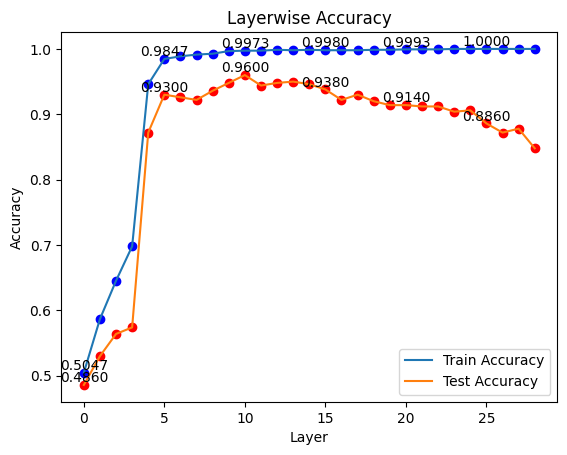

In [7]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
basic_model, basic_tokenizer = load_model(model_id, device)

plot_layerwise_attention_information(grammar_path, basic_model, basic_tokenizer, device)

In [8]:
basic_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((3072,), eps=1e-05)
    (rotary_emb

In [9]:
from numpy import random

def get_blocked_attention_heads(num_layers, num_heads, p_block: float = .1):

    disable_idx = {}
    for layer in range(num_layers):
        disable_idx[layer] = []
        for head in range(num_heads):
            if random.random() < p_block:
                disable_idx[layer].append(head)
    return disable_idx


n_layers = len(basic_model.model.layers)
n_heads = 24

blocked_idx = get_blocked_attention_heads(n_layers, n_heads, p_block=.1)

blocked_model, blocked_tokenizer = load_blocked_attention_model(model_id, blocked_idx, device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


In [11]:
blocked_tokenizer.pad_token = blocked_tokenizer.eos_token

In [10]:
plot_layerwise_attention_information(grammar_path, blocked_model, blocked_tokenizer, device)

 52%|█████▏    | 15/29 [00:30<00:42,  3.01s/it]